<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder)

## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000 # normal dataset
!unzip dataset/data_1000.zip -d ./data1000 # abnormal dataset

Retrieving folder contents
Processing file 1-sRJSDLohsZlEXFJizzz8ovYZDqJfI-V data_100_test.zip
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-sRJSDLohsZlEXFJizzz8ovYZDqJfI-V
To: /content/dataset/data_100_test.zip
100% 113k/113k [00:00<00:00, 41.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 85.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVz

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, title=None):

    plt.plot(loss_train_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train data'], loc=0)
    # plt.show()

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


In [ ]:
path = './data1000/35.5102.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src_1 = './data2000/'
src_2 = './data1000/'

files_1 = os.listdir(src_1)  # get the list of files in the source directory
files_2 = os.listdir(src_2)

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files_1:
    X.append(img_read(src_1,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

for file in files_2:
    X.append(img_read(src_2,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (3000, 56, 56) Y.shape: (3000,)


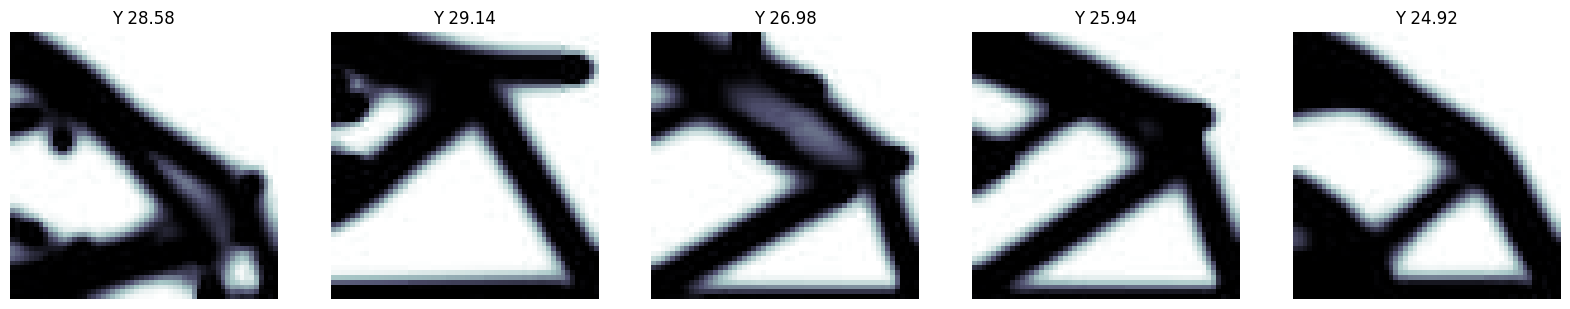

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [ ]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# reshape the (image,image) images into (image*image,) size vectors
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:]))).astype('float32')
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(train_images),np.shape(test_images)))

# convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32)   # don't need to use labels

(2400, 56, 56) (600, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2400,) (600,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## 6. Set to model architecture

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, h_dim),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(h_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, image_size),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

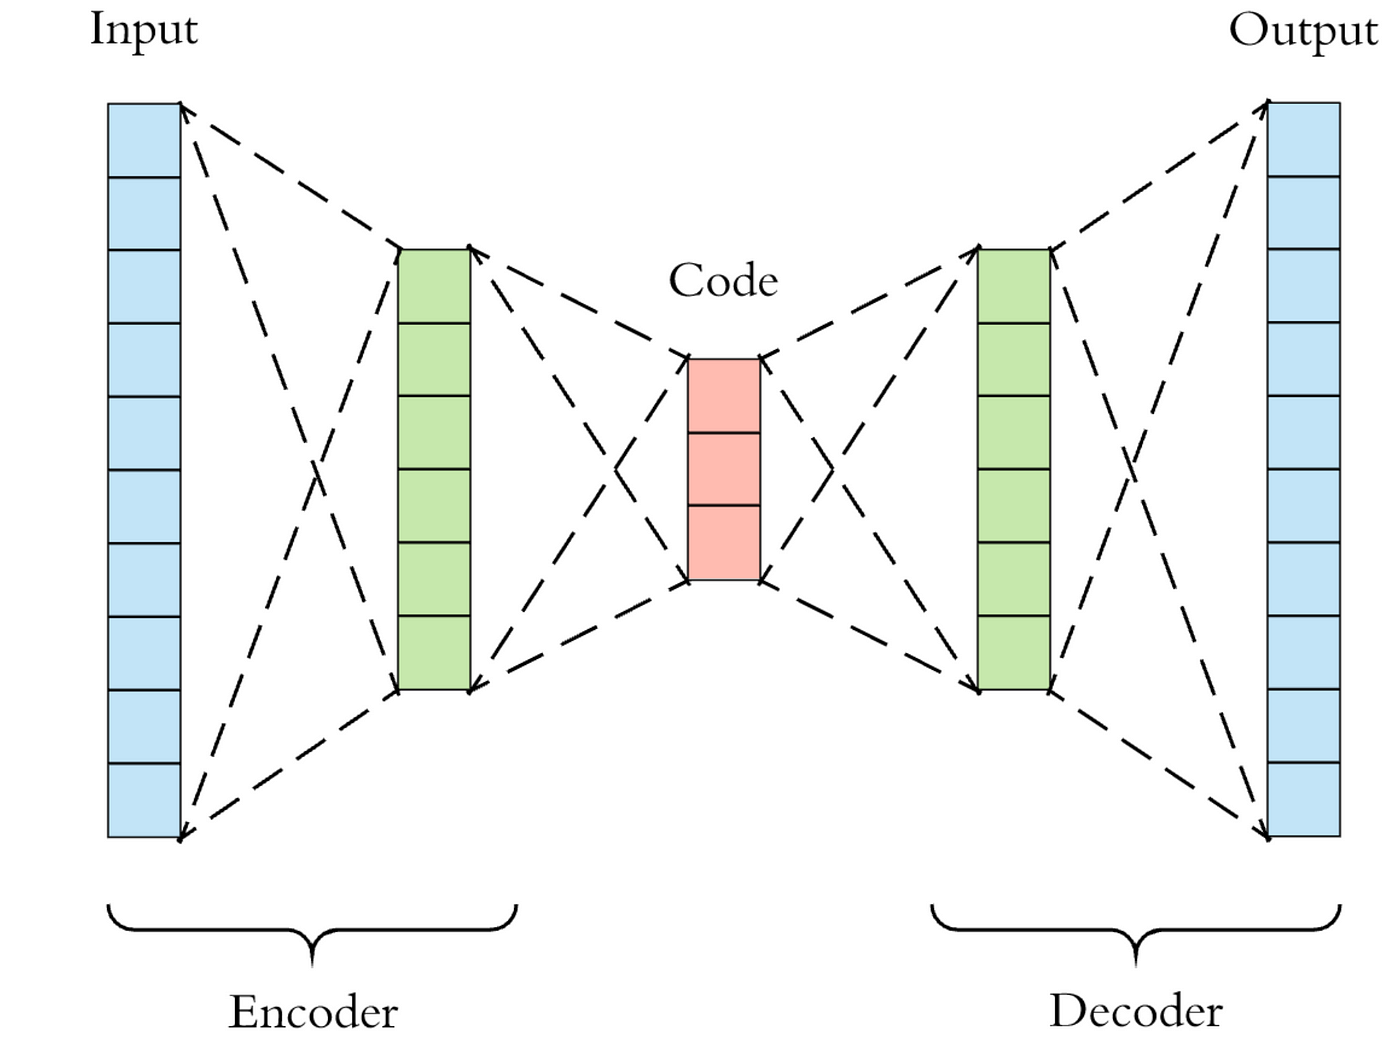

## 7. Set model hyperparameters

In [ ]:
# model architecture parameters
image_size = np.shape(train_images[0])[0]  # (fixed) input size
mid_dim = 512  # hidden layer(middle) dimension
h_dim = 20  # hidden layer(latent) dimension

# training parameters
num_epochs = 200
batch_size = 20
learning_rate = 1e-3

In [ ]:
autoencoder = Autoencoder().to(device)

# print the model's summary
summary(autoencoder, (image_size,))  # input shape: (channels, height, width)

autoencoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 20]          10,260
              ReLU-4                   [-1, 20]               0
            Linear-5                  [-1, 512]          10,752
              ReLU-6                  [-1, 512]               0
            Linear-7                 [-1, 3136]       1,608,768
              ReLU-8                 [-1, 3136]               0
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.34
Estimated Total Size (MB): 12.42
----------------------------------------------------------------


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): ReLU()
  )
)

## 8. Train model

Epoch [1/200], Train_loss: 0.14064485523849726


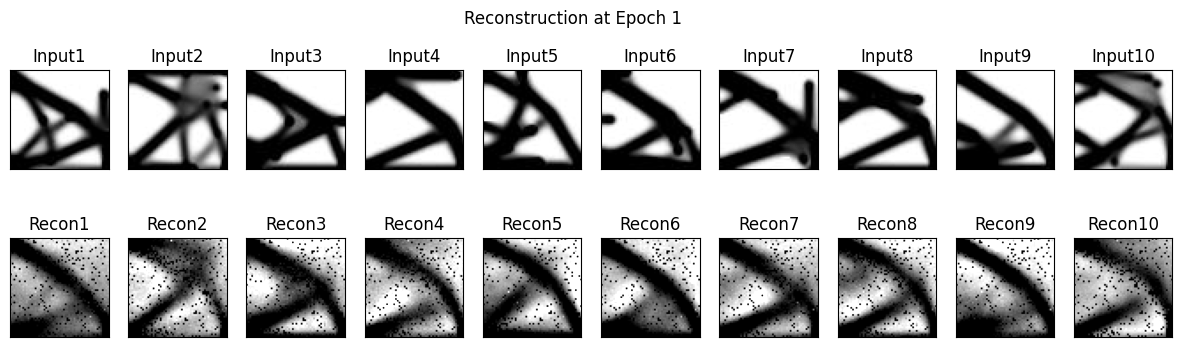

Epoch [2/200], Train_loss: 0.07891761145244042
Epoch [3/200], Train_loss: 0.07003074164191882
Epoch [4/200], Train_loss: 0.06332608728359143
Epoch [5/200], Train_loss: 0.05808896875629822
Epoch [6/200], Train_loss: 0.054851541699220734
Epoch [7/200], Train_loss: 0.05199414615829786
Epoch [8/200], Train_loss: 0.0501630237326026
Epoch [9/200], Train_loss: 0.04881907729431987
Epoch [10/200], Train_loss: 0.047398864291608334
Epoch [11/200], Train_loss: 0.046453545801341534
Epoch [12/200], Train_loss: 0.04569832645356655
Epoch [13/200], Train_loss: 0.045067127266277866
Epoch [14/200], Train_loss: 0.04456919605533282
Epoch [15/200], Train_loss: 0.044215009765078625
Epoch [16/200], Train_loss: 0.043560202388713755
Epoch [17/200], Train_loss: 0.043197264118740954
Epoch [18/200], Train_loss: 0.04274186457817753
Epoch [19/200], Train_loss: 0.042280556603024405
Epoch [20/200], Train_loss: 0.04209061780323585
Epoch [21/200], Train_loss: 0.04136227195461591
Epoch [22/200], Train_loss: 0.04071615543

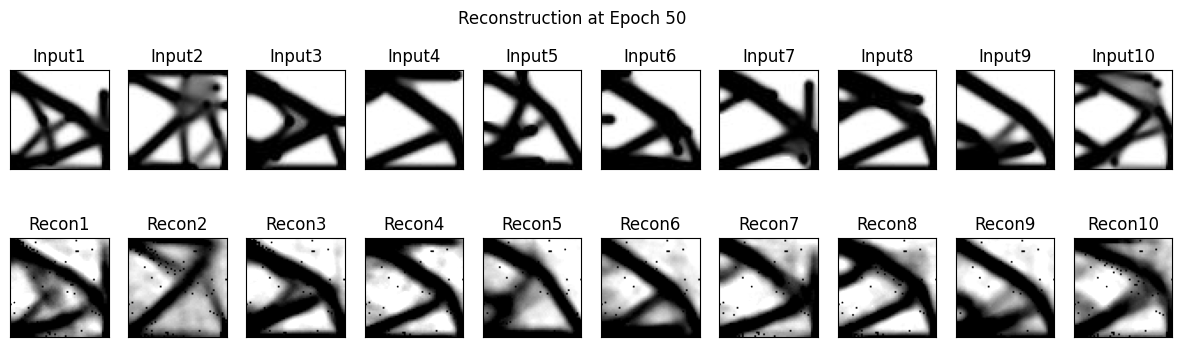

Epoch [51/200], Train_loss: 0.03296250806500514
Epoch [52/200], Train_loss: 0.03297240665803353
Epoch [53/200], Train_loss: 0.03288525630099078
Epoch [54/200], Train_loss: 0.0324022530267636
Epoch [55/200], Train_loss: 0.031886524769167104
Epoch [56/200], Train_loss: 0.032076692286257945
Epoch [57/200], Train_loss: 0.03214811906218529
Epoch [58/200], Train_loss: 0.03182019786909222
Epoch [59/200], Train_loss: 0.03215961335226893
Epoch [60/200], Train_loss: 0.03176833827358981
Epoch [61/200], Train_loss: 0.031570317673807344
Epoch [62/200], Train_loss: 0.03155763374331097
Epoch [63/200], Train_loss: 0.031856113408381743
Epoch [64/200], Train_loss: 0.031480668547252816
Epoch [65/200], Train_loss: 0.0313821271682779
Epoch [66/200], Train_loss: 0.03127507919756075
Epoch [67/200], Train_loss: 0.031037026783451438
Epoch [68/200], Train_loss: 0.031094573702042303
Epoch [69/200], Train_loss: 0.03102715304121375
Epoch [70/200], Train_loss: 0.03073619428711633
Epoch [71/200], Train_loss: 0.03070

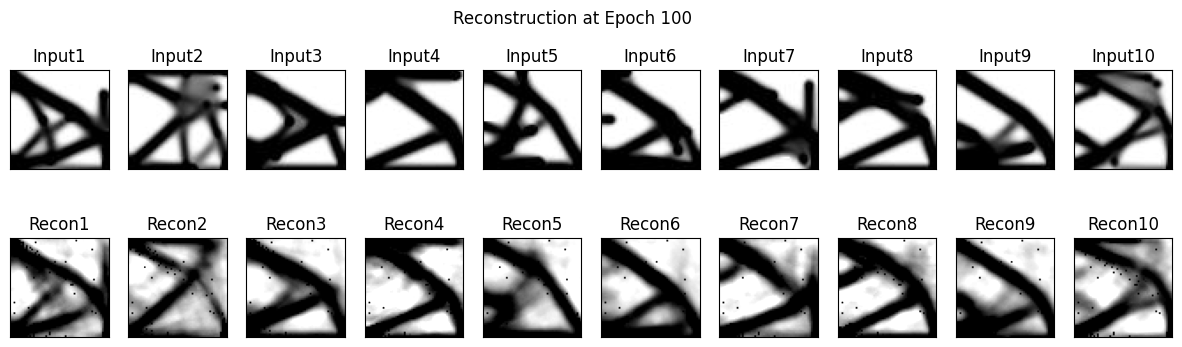

Epoch [101/200], Train_loss: 0.027981628353397053
Epoch [102/200], Train_loss: 0.028155889098222055
Epoch [103/200], Train_loss: 0.027967596768091123
Epoch [104/200], Train_loss: 0.028056495481481154
Epoch [105/200], Train_loss: 0.028041760778675477
Epoch [106/200], Train_loss: 0.027835311430195967
Epoch [107/200], Train_loss: 0.02799821418399612
Epoch [108/200], Train_loss: 0.02773377647002538
Epoch [109/200], Train_loss: 0.02765035832611223
Epoch [110/200], Train_loss: 0.02751156911253929
Epoch [111/200], Train_loss: 0.027622819195191065
Epoch [112/200], Train_loss: 0.027594702256222566
Epoch [113/200], Train_loss: 0.027705610419313114
Epoch [114/200], Train_loss: 0.027431411823878687
Epoch [115/200], Train_loss: 0.027578009680534404
Epoch [116/200], Train_loss: 0.027770171159257492
Epoch [117/200], Train_loss: 0.027547689046089847
Epoch [118/200], Train_loss: 0.02764772013761103
Epoch [119/200], Train_loss: 0.027233527787029744
Epoch [120/200], Train_loss: 0.02729686819948256
Epoch 

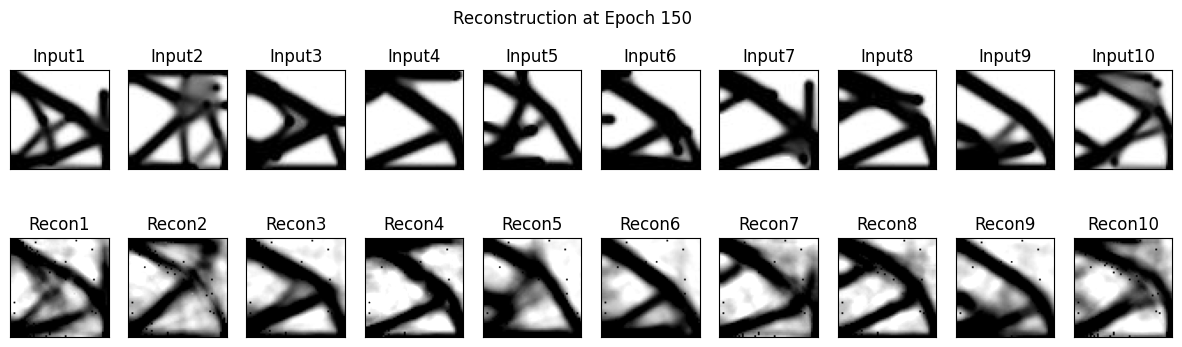

Epoch [151/200], Train_loss: 0.025957606608668964
Epoch [152/200], Train_loss: 0.026046027584622305
Epoch [153/200], Train_loss: 0.0259644264044861
Epoch [154/200], Train_loss: 0.025925035836795965
Epoch [155/200], Train_loss: 0.02580279535613954
Epoch [156/200], Train_loss: 0.025931087881326677
Epoch [157/200], Train_loss: 0.026111309013019005
Epoch [158/200], Train_loss: 0.026094388465086618
Epoch [159/200], Train_loss: 0.025705624340722957
Epoch [160/200], Train_loss: 0.02558175230709215
Epoch [161/200], Train_loss: 0.025855935737490655
Epoch [162/200], Train_loss: 0.02556857788003981
Epoch [163/200], Train_loss: 0.025980814173817635
Epoch [164/200], Train_loss: 0.02559415721334517
Epoch [165/200], Train_loss: 0.02556949135226508
Epoch [166/200], Train_loss: 0.02550375455369552
Epoch [167/200], Train_loss: 0.02565433654623727
Epoch [168/200], Train_loss: 0.02548716451662282
Epoch [169/200], Train_loss: 0.025401155402263006
Epoch [170/200], Train_loss: 0.025468227453529835
Epoch [171

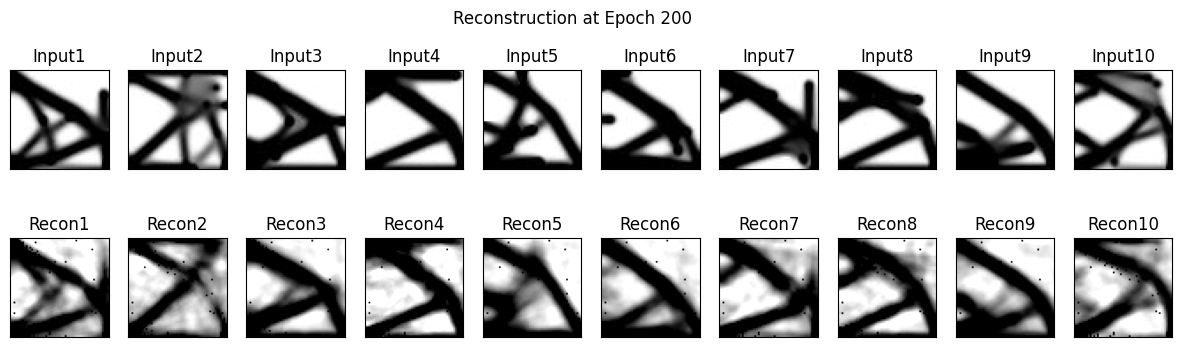

In [ ]:
# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# lists to track training and validation history
loss_train_history = []

# train the model
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # calculate average metrics for the training set
    average_loss_train = total_loss / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train}")

    # perform inference every XX epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        autoencoder.eval()
        recon_x_test = autoencoder(test_images)

        n = 10  # how many images to display
        plt.figure(figsize=(15, 4)) # figure size

        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Input{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Recon{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
        plt.show()
        autoencoder.train()  # switch back to training mode

# save the model
torch.save(autoencoder.state_dict(), 'AE_model.pth')

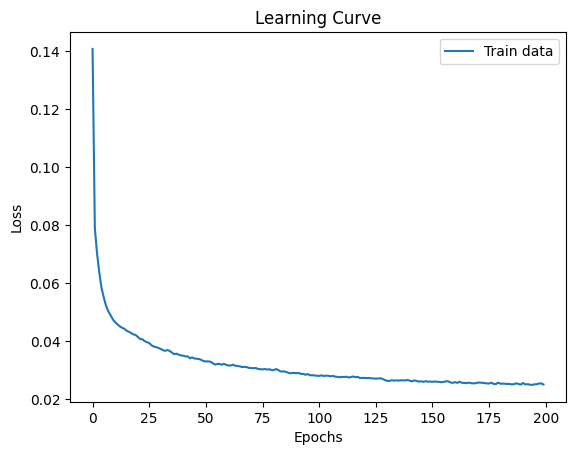

In [ ]:
# graph visualization
plot_loss(loss_train_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

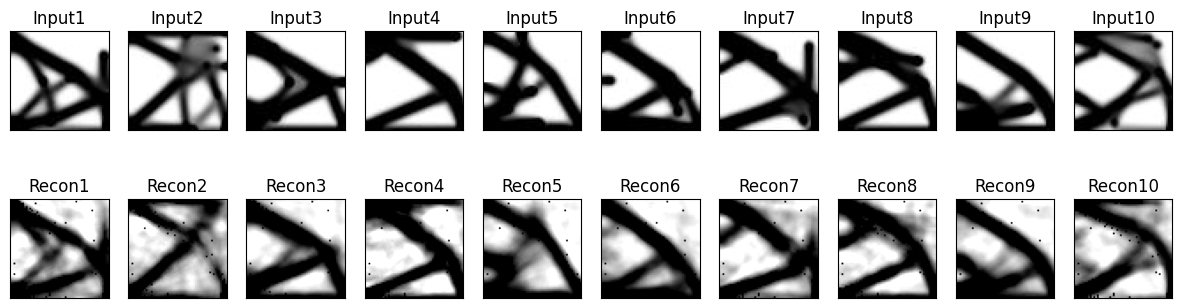

In [ ]:
autoencoder.eval().to(device)

# proceed reconstruction of the bracket images through the trained autoencoder model
recon_x_test = autoencoder(test_images)

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 10. Visualize latent space using t-SNE (t-distributed Stochastic Neighbor Embedding)

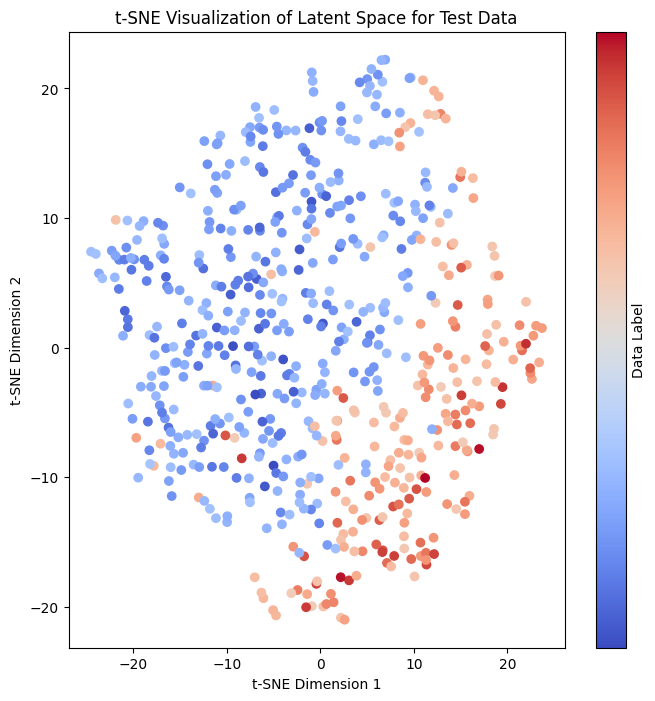

In [ ]:
# set the model to evaluation mode to get the encoded representations without gradients
autoencoder.eval()

with torch.no_grad():  # disable gradient computation for inference
    # get the latent representations (encoded features) for the test dataset
    z_test = autoencoder.encoder(test_images).cpu().detach().numpy()

# apply t-SNE to reduce the latent space to 2 dimensions for visualization
tsne = TSNE(n_components=2, perplexity=40, random_state=0)
z_tsne = tsne.fit_transform(z_test)

# create a scatter plot of the t-SNE results
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=test_labels, cmap='coolwarm')
plt.colorbar(scatter, ticks=[0, 50], label='Data Label')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Latent Space for Test Data")
plt.show()